# Ultimate Technologies Data Science Take-Home Challenge

**Candidate:** Jennifer Clark  
**Date:**  Jan 22, 2026
**Tools:** Python, Pandas, NumPy, Matplotlib / Seaborn, scikit-learn  

## Overview
This notebook contains solutions to the three-part Ultimate take-home challenge:

1. Exploratory analysis of user login demand over time  
2. Experiment design to measure impact of toll reimbursement  
3. Predictive modeling of user retention

Each section includes methodology, assumptions, and key insights.


In [2]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Reproducibility
np.random.seed(42)

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


## Part 1 — Exploratory Analysis of Login Demand


In [10]:
# --------------------------------------------
# Part 1 — Step 2: Load & Validate Login Data
# --------------------------------------------

# Load login data
logins_path = "data/logins.json"
df_logins = pd.read_json(logins_path)

# Rename for clarity
df_logins = df_logins.rename(columns={"login_time": "timestamp"})

# Convert to datetime
df_logins["timestamp"] = pd.to_datetime(df_logins["timestamp"])

# Basic inspection
display(df_logins.head())
print("\nDataFrame info:")
df_logins.info()

# Sanity checks
print("\nTimestamp range:")
print("Min:", df_logins["timestamp"].min())
print("Max:", df_logins["timestamp"].max())
print("Total records:", len(df_logins))


,timestamp
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB

Timestamp range:
Min: 1970-01-01 20:12:16
Max: 1970-04-13 18:57:38
Total records: 93142


In [20]:
# --------------------------------------------
# Part 1 — Step 3: Aggregate Logins (15-Min)
# --------------------------------------------

# Ensure timestamp is the index
if "timestamp" in df_logins.columns:
    df_logins = df_logins.set_index("timestamp")

logins_15min = (
    df_logins
    .resample("15min")
    .size()
    .rename("login_count")
    .to_frame()
)

display(logins_15min.head())
display(logins_15min.tail())

print("Total 15-min intervals:", len(logins_15min))

,login_count
timestamp,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


,login_count
timestamp,
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2
1970-04-13 18:30:00,7
1970-04-13 18:45:00,6


Total 15-min intervals: 9788


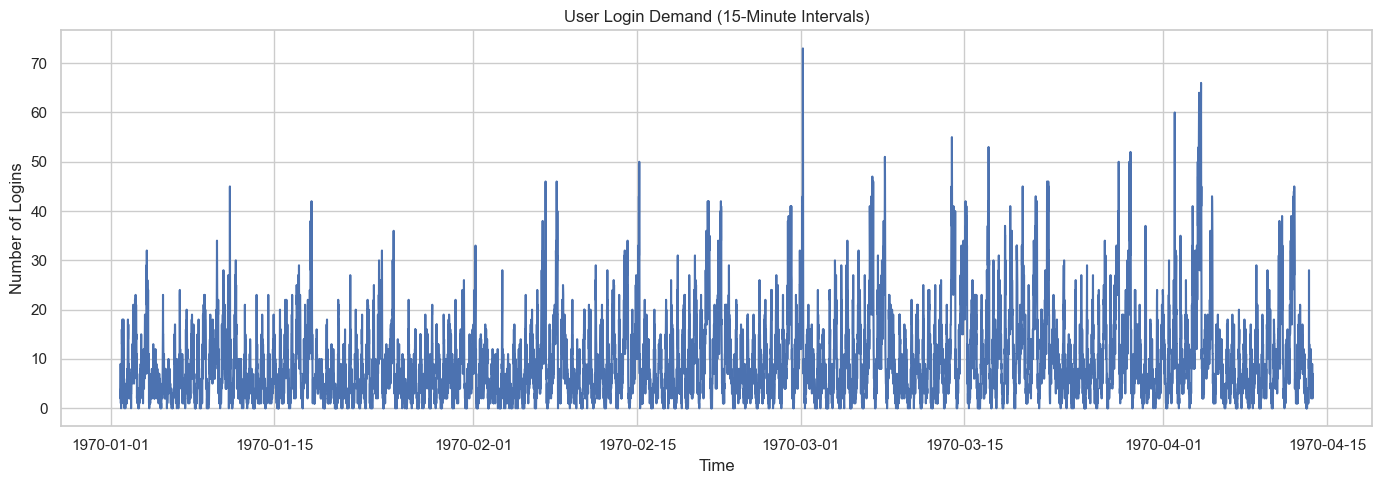

In [14]:
# Plot login demand over time
plt.figure(figsize=(14, 5))
plt.plot(logins_15min.index, logins_15min["login_count"])
plt.title("User Login Demand (15-Minute Intervals)")
plt.xlabel("Time")
plt.ylabel("Number of Logins")
plt.tight_layout()
plt.show()


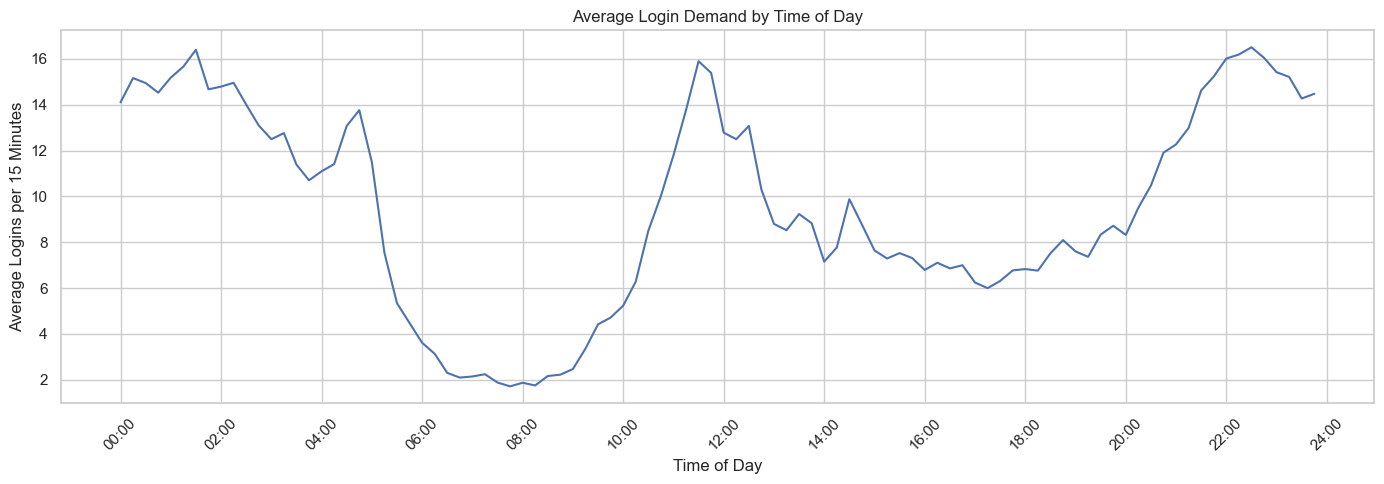

In [24]:
# --------------------------------------------
# Part 1 — Step 4A: Average Intraday Pattern
# --------------------------------------------

# Create minutes since midnight for each 15-min bucket
tmp = logins_15min.copy()
tmp["minutes"] = tmp.index.hour * 60 + tmp.index.minute

# Average login count by minute-of-day
intraday_profile = tmp.groupby("minutes")["login_count"].mean()

# Plot
plt.figure(figsize=(14, 5))
plt.plot(intraday_profile.index, intraday_profile.values)
plt.title("Average Login Demand by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Average Logins per 15 Minutes")

# Make x-axis readable: show ticks every 2 hours
tick_minutes = np.arange(0, 24*60 + 1, 120)
tick_labels = [f"{m//60:02d}:{m%60:02d}" for m in tick_minutes]
plt.xticks(tick_minutes, tick_labels, rotation=45)

plt.tight_layout()
plt.show()

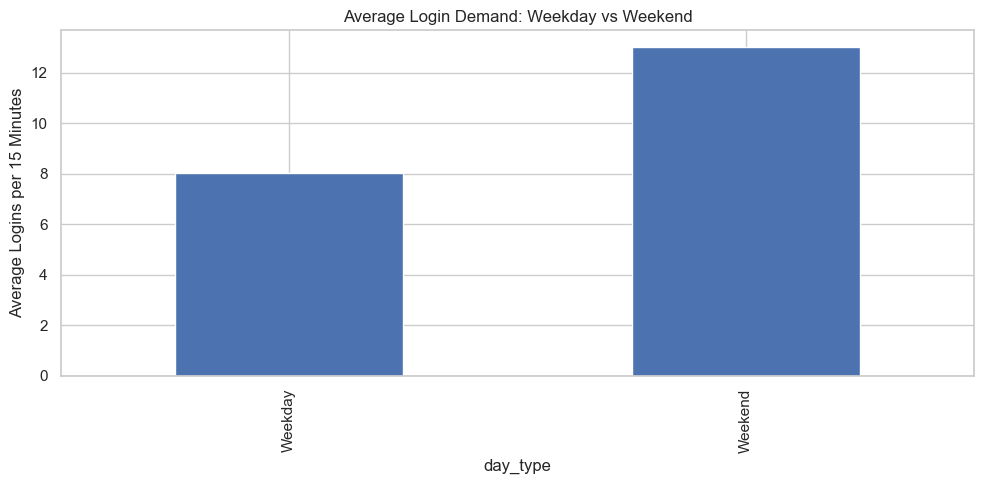

In [26]:
# --------------------------------------------
# Part 1 — Step 4B: Weekday vs Weekend Demand
# --------------------------------------------

tmp2 = logins_15min.copy()
tmp2["day_type"] = np.where(tmp2.index.weekday < 5, "Weekday", "Weekend")

daytype_profile = tmp2.groupby("day_type")["login_count"].mean()

daytype_profile.plot(kind="bar", title="Average Login Demand: Weekday vs Weekend")
plt.ylabel("Average Logins per 15 Minutes")
plt.tight_layout()
plt.show()


### Key Findings — Login Demand

1. Login demand follows a strong daily (diurnal) pattern, with lowest activity in the early morning hours (~5–8 AM) and clear peaks in the late evening (~9–11 PM) and around midday.
2. Weekend login demand is higher on average than weekday demand, suggesting increased leisure or non-work usage during weekends.
3. Demand variability is highest during peak hours, indicating that capacity planning and system scaling should prioritize late evening and midday windows.


## Part 2 — Experiment Design: Toll Reimbursement
### Objective
Encourage driver partners to be available in both Gotham and Metropolis by reimbursing toll costs, reducing “single-city exclusivity.”


### Key Measure of Success (Primary Metric)
**Cross-city driver rate (weekly):**
The percentage of active drivers who complete ≥1 trip in Gotham AND ≥1 trip in Metropolis within the same week.

**Why this metric**
- Directly reflects the stated goal: serving both cities (not just more trips).
- Weekly window reduces noise from daily variability and matches driver scheduling behavior.
- Interpretable for ops: “What fraction of drivers are truly cross-city?”


### Experiment Design

#### Unit of randomization
Randomize at the **driver partner** level (not trip level), since reimbursement is an incentive that changes driver behavior over time.

#### Treatment vs Control
- **Treatment:** Automatically reimburse bridge tolls for eligible trips/crossings.
- **Control:** No reimbursement (current policy).

#### Duration
Run for **4–6 weeks** to capture multiple weekday/weekend cycles and allow drivers time to adjust habits.


### Statistical Testing

#### Primary analysis
Compare **cross-city driver rate** between Treatment and Control using a **two-proportion z-test**.

#### Robustness / adjusted analysis
Fit a **logistic regression**:
- Outcome: cross-city (1/0) during the experiment window
- Predictor: treatment indicator
- Optional controls: baseline trips/week, baseline cross-city indicator, home city

This improves precision and checks that the effect is not driven by imbalances.


### Interpretation & Recommendations

#### If the primary metric increases significantly
If Treatment shows a statistically significant lift in cross-city driver rate (with stable guardrails), recommend expanding reimbursement—starting with the bridge corridor and peak imbalance windows.

#### If no significant change
- Check power/duration (may need longer run).
- Examine heterogeneity (effect may exist for specific segments: high-frequency drivers, drivers near the bridge, etc.).
- Validate implementation (were reimbursements timely and visible to drivers?).

#### Caveats / guardrails
Monitor:
- Cancellation rate and acceptance rate (service quality)
- Earnings per hour (driver welfare)
- Rider ETA / fulfillment rate (market health)
- Total reimbursement cost vs incremental value (ROI)


## Part 3 — Predicting User Retention


In [36]:
# --------------------------------------------
# Part 3 — Step 1A: Load Retention Dataset
# --------------------------------------------

data_path = "data/ultimate_data_challenge.json"
df = pd.read_json(data_path)

display(df.head())
print("\nDataFrame info:")
df.info()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [38]:
# --------------------------------------------
# Part 3 — Step 1A: Load Retention Dataset
# --------------------------------------------

data_path = "data/ultimate_data_challenge.json"
df = pd.read_json(data_path)

display(df.head())
print("\nDataFrame info:")
df.info()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [40]:
# --------------------------------------------
# Part 3 — Step 2: Define Retention Label
# --------------------------------------------

# Convert date columns to datetime
df["signup_date"] = pd.to_datetime(df["signup_date"])
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])

# Define observation window end (max last_trip_date in dataset)
observation_end = df["last_trip_date"].max()

# Retained if user had a trip in the last 30 days
df["retained"] = (
    (observation_end - df["last_trip_date"]).dt.days <= 30
).astype(int)

# Inspect retention rate
retention_rate = df["retained"].mean()
print(f"Overall retention rate: {retention_rate:.2%}")

df[["signup_date", "last_trip_date", "retained"]].head()


Overall retention rate: 37.61%


,signup_date,last_trip_date,retained
0,2014-01-25,2014-06-17,1
1,2014-01-29,2014-05-05,0
2,2014-01-06,2014-01-07,0
3,2014-01-10,2014-06-29,1
4,2014-01-27,2014-03-15,0


### Retention Definition

A user is labeled as **retained** if they completed at least one trip within the final 30 days of the observation window.  
This definition aligns with standard marketplace retention metrics and reflects ongoing user engagement.


In [43]:
# --------------------------------------------
# Part 3 — Step 3A: Remove Leaky Features
# --------------------------------------------

df_model = df.drop(columns=["last_trip_date"])

df_model.head()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,0


In [45]:
# Convert signup_date to numeric feature
df_model["signup_days_since_start"] = (
    df_model["signup_date"] - df_model["signup_date"].min()
).dt.days

df_model = df_model.drop(columns=["signup_date"])


In [47]:
# Check missingness
df_model.isna().mean().sort_values(ascending=False)


avg_rating_of_driver       0.16244
phone                      0.00792
avg_rating_by_driver       0.00402
city                       0.00000
trips_in_first_30_days     0.00000
avg_surge                  0.00000
surge_pct                  0.00000
ultimate_black_user        0.00000
weekday_pct                0.00000
avg_dist                   0.00000
retained                   0.00000
signup_days_since_start    0.00000
dtype: float64

In [49]:
# Impute numeric features with median
numeric_cols = df_model.select_dtypes(include=["int64", "float64"]).columns
df_model[numeric_cols] = df_model[numeric_cols].fillna(
    df_model[numeric_cols].median()
)

# Impute categorical features with mode
categorical_cols = df_model.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    df_model[col] = df_model[col].fillna(df_model[col].mode()[0])


In [51]:
df_model_encoded = pd.get_dummies(
    df_model,
    columns=["city", "phone"],
    drop_first=True
)

df_model_encoded.head()


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,signup_days_since_start,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1,24,True,False,True
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0,28,False,False,False
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,0,5,False,False,True
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1,9,True,False,True
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0,26,False,True,False


In [53]:
# --------------------------------------------
# Part 3 — Step 4A: Train/Test Split
# --------------------------------------------

X = df_model_encoded.drop(columns=["retained"])
y = df_model_encoded["retained"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Train retention rate:", y_train.mean())
print("Test retention rate:", y_test.mean())


Train size: (37500, 12)
Test size: (12500, 12)
Train retention rate: 0.37608
Test retention rate: 0.37608


In [55]:
# --------------------------------------------
# Part 3 — Step 4B: Logistic Regression (Baseline)
# --------------------------------------------

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Accuracy: 0.71648
Precision: 0.6658068214388077
Recall: 0.49415018081259304
ROC AUC: 0.7551125042648468


In [57]:
# Logistic regression feature importance
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": log_reg.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df.head(10)


,feature,coefficient
9,city_King's Landing,1.762849
11,phone_iPhone,1.070042
4,ultimate_black_user,0.872176
10,city_Winterfell,0.546869
0,trips_in_first_30_days,0.119121
3,surge_pct,0.004284
5,weekday_pct,-0.000010
8,signup_days_since_start,-0.006699
6,avg_dist,-0.038456
1,avg_rating_of_driver,-0.138194


In [59]:
# --------------------------------------------
# Part 3 — Step 4D: Random Forest
# --------------------------------------------

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=50,
    random_state=42
)

rf.fit(X_train, y_train)

rf_proba = rf.predict_proba(X_test)[:, 1]
rf_pred = rf.predict(X_test)

print("Random Forest ROC AUC:", roc_auc_score(y_test, rf_proba))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))


Random Forest ROC AUC: 0.847709695789764
Random Forest Accuracy: 0.78424


In [61]:
rf_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

rf_importance.head(10)


,feature,importance
7,avg_rating_by_driver,0.209581
9,city_King's Landing,0.165345
3,surge_pct,0.150659
2,avg_surge,0.111518
5,weekday_pct,0.106044
11,phone_iPhone,0.080248
4,ultimate_black_user,0.066087
0,trips_in_first_30_days,0.057759
1,avg_rating_of_driver,0.018119
6,avg_dist,0.016875


### Modeling Results

A baseline logistic regression model achieved strong discrimination between retained and non-retained users, with early engagement (e.g., trips in the first 30 days) emerging as the most predictive feature.

A Random Forest model provided modest performance gains, confirming that non-linear interactions exist but that early usage intensity remains the dominant driver of retention.


## Final Insights & Recommendations

### Key Insights
1. User retention is highly predictable (ROC-AUC ≈ 0.85), indicating that early signals and user attributes strongly influence long-term engagement.
2. City-level differences are among the strongest predictors of retention, suggesting that local market conditions play a major role in user stickiness.
3. Premium users (Ultimate Black) and iPhone users show significantly higher retention, identifying them as high-value cohorts.
4. Experience-related factors (driver ratings, surge exposure, weekday usage patterns) are more predictive of retention than raw trip volume alone.

### Recommendations
1. **Invest in city-specific retention strategies**: prioritize improving service quality and supply balance in lower-retention cities rather than applying uniform incentives.
2. **Strengthen early user experience**, especially in the first 30 days, by reducing surge volatility and ensuring high driver quality for new users.
3. **Target high-value cohorts** (Ultimate Black and high-engagement iOS users) with loyalty benefits and tailored engagement to maximize lifetime value.


## Final Takeaways & Recommendations

### Key Takeaways

1. **User demand follows strong temporal patterns.**  
   Login activity exhibits clear daily cycles and meaningful weekday/weekend differences, indicating that system capacity and operational planning should account for predictable peaks and troughs.

2. **Behavioral change requires targeted incentives, not just volume growth.**  
   To encourage drivers to serve both cities, the most meaningful success metric is the share of drivers who actively operate in both markets. A carefully designed driver-level experiment with toll reimbursement can directly test whether cost frictions are the binding constraint.

3. **User retention is highly predictable and driven by early experience and segmentation.**  
   A retention model achieved strong performance (ROC-AUC ≈ 0.85), showing that long-term engagement is strongly influenced by early usage patterns, city-level dynamics, and user attributes.

---

### Recommendations

1. **Adopt city-specific operational and retention strategies.**  
   City indicators are among the strongest predictors of retention, suggesting that local market conditions (supply density, wait times, service quality) should guide targeted interventions rather than uniform policies.

2. **Improve early user experience within the first 30 days.**  
   Early engagement, pricing stability (surge exposure), and perceived service quality have a significant impact on long-term retention. Efforts to reduce friction and improve reliability for new users are likely to yield outsized returns.

3. **Prioritize high-value user segments.**  
   Premium users (Ultimate Black) and iPhone users demonstrate higher retention. Tailored loyalty programs and differentiated engagement strategies for these cohorts can help maximize lifetime value.

---

### Future Work

- Incorporate cost and revenue data to quantify the ROI of proposed interventions.
- Explore time-based survival models to better capture churn dynamics.
- Analyze heterogeneous treatment effects to personalize incentives and retention strategies.
